In [ ]:
import os
import cv2

def resize_frames(input_folder, output_folder, target_size):
    for frame_file in os.listdir(input_folder):
        frame_path = os.path.join(input_folder, frame_file)
        
        # Read the frame
        frame = cv2.imread(frame_path)
        
        # Check if frame is empty
        if frame is None:
            print("Error: Unable to read the frame. Check if the frame is empty.")
            continue
        
        # Resize the frame
        resized_frame = cv2.resize(frame, target_size)
        
        # Create output path
        output_path = os.path.join(output_folder, frame_file)
        
        # Write the resized frame to disk
        cv2.imwrite(output_path, resized_frame)

# Example usage
input_frames_folder = r'C:\Users\rickyswas\OneDrive\Desktop\CNNs\dataset_lab8\images'
output_resized_frames_folder = r'C:\Users\rickyswas\OneDrive\Desktop\CNNs\dataset_lab8\images_resized'
target_size = (640, 640)  # Specify your desired dimensions

resize_frames(input_frames_folder, output_resized_frames_folder, target_size)


In [ ]:
import cv2
import os
def normalize_resized_frames(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    frame_files = [f for f in os.listdir(input_folder) if f.endswith('.jpg')]
    for frame_file in frame_files:
        frame_path = os.path.join(input_folder, frame_file)
        frame = cv2.imread(frame_path)
        #Normalize pixel values to the range [0, 1]
        normalized_frame = frame / 255.0
        output_path = os.path.join(output_folder, frame_file)
        cv2.imwrite(output_path, normalized_frame * 255.0)
resized_frames_folder_path = r'C:\Users\rickyswas\OneDrive\Desktop\CNNs\dataset_lab8\images_resized'
normalized_frames_folder_path = r'C:\Users\rickyswas\OneDrive\Desktop\CNNs\dataset_lab8\images_normalized'
normalize_resized_frames(resized_frames_folder_path, normalized_frames_folder_path)

In [ ]:
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def augment_frames(input_folder, output_folder, augmentations_per_image=3):
    os.makedirs(output_folder, exist_ok=True)
    frame_files = [f for f in os.listdir(input_folder) if f.endswith('.jpg')]
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )
    for frame_file in frame_files:
        frame_path = os.path.join(input_folder, frame_file)
        frame = cv2.imread(frame_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame.reshape((1,) + frame.shape)
        #Generating augmented images
        for i, batch in enumerate(datagen.flow(frame, batch_size=1, save_to_dir=output_folder, save_prefix=f"{frame_file[:-4]}_aug", save_format='jpg')):
            if i >= augmentations_per_image:
                break
resized_normalized_frames_folder_path = r'C:\Users\rickyswas\OneDrive\Desktop\CNNs\dataset_lab8\images_normalized'
augmented_frames_folder_path = r'C:\Users\rickyswas\OneDrive\Desktop\CNNs\dataset_lab8\images_augmented_less'
augment_frames(resized_normalized_frames_folder_path, augmented_frames_folder_path)


0: 640x640 1 person, 1 motorcycle, 416.1ms
Speed: 15.6ms preprocess, 416.1ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 640)
Confidence ---> 0.79
Class name --> bus
Confidence ---> 0.65
Class name --> Unknown


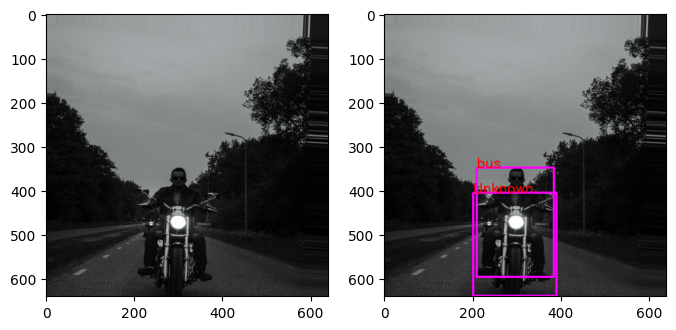

In [3]:
import cv2
import math 
import yaml
from ultralytics import YOLO
import matplotlib.pyplot as plt

with open("vehicles.yaml", "r") as file:
    config = yaml.safe_load(file)

img = cv2.imread(r'C:\Users\rickyswas\OneDrive\Desktop\CNNs\dataset_lab8\test\pexels-bas-masseus-1253639_aug_0_8917.jpg')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,8))
ax[0].imshow(img)
# plt.imshow(img)

model = YOLO("yolov8n.pt")

classNames = config['names']

results = model(img)

# Coordinates
for r in results:
    boxes = r.boxes

    for box in boxes:
        # Bounding box
        x1, y1, x2, y2 = box.xyxy[0]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)  # Convert to int values

        # Put box in image
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 255), 3)

        # Confidence
        confidence = math.ceil((box.conf[0] * 100)) / 100
        print("Confidence --->", confidence)

        # Class name
        cls = int(box.cls[0])
        class_name = classNames[cls] if 0 <= cls < len(classNames) else "Unknown"
        print("Class name -->", class_name)

        # Object details
        org = [x1, y1]
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 1
        color = (255, 0, 0)
        thickness = 2

        cv2.putText(img, class_name, org, font, fontScale, color, thickness)

# Display image with detections
# print(img)
# plt.imshow(img)
# plt.show()
ax[1].imshow(img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


0: 640x640 (no detections), 554.9ms
Speed: 15.6ms preprocess, 554.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


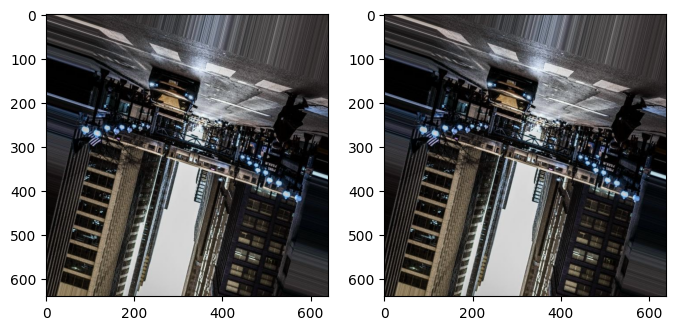

In [7]:
import cv2
import math 
import yaml
from ultralytics import YOLO
import matplotlib.pyplot as plt

with open("vehicles.yaml", "r") as file:
    config = yaml.safe_load(file)

img = cv2.imread(r'C:\Users\rickyswas\OneDrive\Desktop\CNNs\dataset_lab8\train\pexels-cameron-casey-1152866_aug_0_227.jpg')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,8))
ax[0].imshow(img)
# plt.imshow(img)

model = YOLO("yolov8n.pt")

classNames = config['names']

results = model(img)

# Coordinates
for r in results:
    boxes = r.boxes

    for box in boxes:
        # Bounding box
        x1, y1, x2, y2 = box.xyxy[0]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)  # Convert to int values

        # Put box in image
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 255), 3)

        # Confidence
        confidence = math.ceil((box.conf[0] * 100)) / 100
        print("Confidence --->", confidence)

        # Class name
        cls = int(box.cls[0])
        class_name = classNames[cls] if 0 <= cls < len(classNames) else "Unknown"
        print("Class name -->", class_name)

        # Object details
        org = [x1, y1]
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 1
        color = (255, 0, 0)
        thickness = 2

        cv2.putText(img, class_name, org, font, fontScale, color, thickness)

# Display image with detections
# print(img)
# plt.imshow(img)
# plt.show()
ax[1].imshow(img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()